## Wastewater Surveillance Data 

This code uses Healthy Davis Together (HDT) wastewater surveillance data and considers how disease dynamics in sub-sewershed zones compare to overall city disease trends.

Importing the necessary libraries below:

In [1]:
%%capture
!pip install folium;
import folium
from folium.plugins import MarkerCluster
!pip install geopandas
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
!pip install numpy 
import numpy as np
import seaborn as sns
from scipy.stats import trim_mean
from scipy.stats import spearmanr

import matplotlib.dates as mdates

import math

#For the wastewater processor 
import fiona 
pd.set_option('display.max_columns', None)
import os
import datetime
import tqdm
import time
from collections import defaultdict, Counter

The Census blocks in California were uploaded and filtered to obtain only the blocks in Yolo County.

In [2]:
ca_blocks = gpd.read_file("/Users/amitamuralidharan/Desktop/wbe_files/tl_2020_06_tabblock20") #Insert the correct file directory here.
ca_blocks["GEOID20"] = ca_blocks.GEOID20.str.lstrip("0")
yolo_blocks = ca_blocks[ca_blocks["COUNTYFP20"]=="113"]
yolo_blocks = yolo_blocks.rename(columns={"GEOID20":"GEOID"})
yolo_blocks.head(2)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry
2,06,113,010103,2011,61130101032011,Block 2011,G5040,U,77068,U,S,152151,0,+38.5874284,-121.5303753,0,0,"POLYGON ((-121.53676 38.58855, -121.53421 38.5..."
3,06,113,011500,1002,61130115001002,Block 1002,G5040,R,NaN,NaN,S,2750738,0,+38.8853304,-122.2439514,18,25,"POLYGON ((-122.25881 38.90023, -122.25799 38.8..."


A preliminary map of Davis was created, including the city boundaries and sampling nodes.

In [3]:
#Creating folium map with COD boundaries and census blocks

#Defining and creating a basemap using folium
davis_coords = [38.544907, -121.740517]

davis_map = folium.Map(
    location = davis_coords, 
    zoom_start = 12.5, 
    zoom_control=False, 
    scrollWheelZoom=False, 
    dragging=False,
    tiles="CartoDB positron")

#Uploading shape file with CA city boundaries
ca_boundaries = gpd.read_file("/Users/amitamuralidharan/Desktop/wbe_files/davis_city_boundary") #Insert the correct file directory here.

#Extracting City of Davis boundaries
davis_boundaries = ca_boundaries[ca_boundaries["CITY"]=="Davis"]

#Changing coordinate reference system to a geographic coordinate system
#This is the information needed to plot the city atop the folium basemap
davis_boundaries = davis_boundaries.to_crs(epsg=4326)

#We want to create a dataframe with the Census blocks in Davis.
for _, r in yolo_blocks.iterrows():
    #We might need to simplify the representation of each block so that the map displays, in this case use .simplify
    sim_geo = gpd.GeoSeries(r["geometry"])
    #.simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda feature: {
        'fillColor':'None', 
        'color':'black',
        'weight':0.5}) 
        #'dashArray':'5,5'})
    folium.Popup(r['GEOID']).add_to(geo_j)
    geo_j.add_to(davis_map)

#Uploading City of Davis (COD) maintenance hole (MH) data
cod_mh = pd.read_csv("/Users/amitamuralidharan/Desktop/wbe_files/SRmap_CODMH.csv") #Insert the correct file directory here.

#Plotting sampling locations on the map
for i, row in cod_mh.iterrows():
    folium.CircleMarker(location=[row['Lat'], row['Long']], radius=3, weight=2, color="maroon", fill=True, fill_opacity=0.7).add_to(davis_map)

#davis_map 

## Subregional Sewershed Zone Definitions

Next, we'll assign census blocks to sewershed zones.

In [4]:
#SUBREGIONAL ZONES

#SR-A, N10-004
SR_A_cb = ['61130105052025','61130105051017','61130105051018','61130105081000','61130105081003','61130105081004','61130105081001',
                     '61130105081007','61130105081006','61130105112003','61130105121000','61130105121008','61130105121001','61130105112001',
                     '61130105112002','61130105121007','61130105121003','61130105121005','61130105122000','61130105112004','61130105111000',
                     '61130105111002','61130105111003','61130105111005','61130105111001','61130105082002','61130105082004','61130105082005',
                     '61130105082009','61130105082008','61130105082007','61130105132003','61130105132002','61130105081005','61130105082003',
                     '61130105081008','61130105132000','61130105131000','61130105131001','61130105122011','61130105122010','61130105122013',
                     '61130105122006','61130105122007','61130105122004','61130105121004''61130105121006','61130105121004','61130105122005',
                     '61130105122012','61130105122009','61130105122008','61130105082006','61130105112000','61130105082001','61130105052027',
                     '61130105081002','61130105111004','61130105132001','61130105121006','61130105122003','61130105122001','61130105122002','61130105121002']
#SR-B1, N11-062
SR_B_1_cb = ['61130105101004','61130105102000','61130105103004']

#SR-B2, N11-072
SR_B_2_cb = ['61130105102000','61130105102003','61130105102004','61130105102002','61130105102001','61130105103005','61130105091003',
                    '61130105091000','61130105091004','61130105091005']

#SR-B3, N12-066
SR_B_3_cb = ['61130105102000','61130105101004','61130105101006','61130105101005','61130105104002','61130105104001','61130105104003',
                    '61130105091000','61130105091005','61130105091002','61130105091001','61130105092002','61130105092004','61130105092006',
                    '61130105092003','61130105092002','61130105092002','61130105092005']

#SR-B4, N13-041
SR_B_4_cb = ['61130105092002','61130105092010','61130105092009','61130105092008','61130105092012','61130105092011']

#SR-C1, O12-005
SR_C_1_cb = ['61130107031001','61130107031003','61130107031004','61130107031002','61130107031000','61130107032000','61130107032001',
                          '61130107032003','61130107032004','61130107033000','61130107032011','61130107032012','61130107032013','61130107032014',
                          '61130107032010','61130107032002','61130107032005','61130107032009','61130107032006','61130107033002','61130107033003',
                          '61130107032015','61130107032016','61130107032007','61130107032006','61130107032008','61130107041001','61130107041002',
                          '61130107041003']

#SR-C2, O13-002
#Overlaps with SR-C3
SR_C_2_cb = ['61130107033000','61130107033002','61130107033003','61130107032015','61130107032016','61130107032007','61130107032006','61130107032008',
                    '61130107033001','61130107034003','61130107034002','61130107034004','61130107034000','61130107033006','61130107033005','61130107033001',
                    '61130107033000','61130107041009','61130107041018','61130107041019','61130107041012','61130107041013','61130107041017','61130107041016',
                    '61130107041021','61130107041020','61130107041014','61130107041015','61130107011013','61130107011016','61130107011005','61130107011004',
                    '61130107011007','61130107011008','61130107011006','61130107011012','61130107011009','61130107011010','61130107011011','61130107012003',
                    '61130107012004','61130107012000','61130107012008','61130107012007','61130107012005','61130107012006','61130107012002','61130107012001',
                    '61130107012011','61130107012010','61130107012009','61130107013003','61130107013002','61130107013001','61130107013000','61130107014000',
                    '61130107013019','61130107013004','61130107013005','61130107013006','61130107013007','61130107013008','61130107013009','61130107013010',
                    '61130107013011','61130107013012','61130107013018','61130107013017','61130107013016','61130107013015','61130107013014','61130107013013',
                    '61130107014009','61130107014008','61130107014007','61130107014006','61130107014005','61130107014004','61130107014003','61130107014002',
                    '61130107014001','61130107014010','61130107014011','61130107014012','61130107014013','61130107014014','61130107014015','61130107014016',
                    '61130107014017','61130107014018','61130107014019','61130107014036','61130107014035','61130107014034','61130107014033','61130107014032',
                    '61130107014020','61130107014021','61130107014022','61130107014023','61130107014024','61130107014025','61130107014026','61130107014027',
                    '61130107014028','61130107014029','61130107014030','61130107014031','61130107014038','61130107014039','61130107014037','61130107014040',
                    '61130105012026','61130105012017','61130105012015','61130105012016','61130105012014',
                    '61130106023007','61130106022013','61130106022012','61130106022011','61130106022006','61130106022007',
                    '61130106022014','61130106022015','61130106022010','61130106022009','61130106022008','61130106022016',
                    '61130106022017','61130106022018','61130106024000','61130106102011','61130106102004','61130106102012',
                    '61130106102009','61130106102005','61130106102015','61130106023007','61130106102010','61130106084001',
                    '61130106084003','61130106084002','61130106084004','61130106084011','61130107041006','61130107011003','61130107041011','61130106024001']

#SR-D, N14-031
SR_D_cb = ['61130105052036','61130105052038','61130105052040','61130105052045','61130105052050','61130105052048','61130105052044','61130105052046',
              '61130105052041','61130105052043','61130105052049','61130105052037','61130105052047','61130105052042','61130105052039']

#SR-E, O14-020
SR_E_cb = ['61130106025001','61130106021000','61130106025002','61130106025003','61130106025004','61130106025000']

#SR-F1, O14-008
SR_F_1_cb = ['61130106022003','61130106022004','61130106022002','61130106022005','61130106022001','61130106022000','61130106111013',
                           '61130106111011','61130106111010','61130106111011','61130106111012','61130106111004','61130106111003','61130106111002',
                           '61130106111001','61130106111005','61130106111000','61130106092012','61130106092013','61130106092014','61130106111008',
                           '61130106111007']

#SR-F2, P14-027
SR_F_2_cb = ['61130106023004','61130106023003','61130106023002','61130106023000','61130106023005','61130106023006','61130106023001','61130106111014',
                           '61130106111009','61130106111006','61130106111007']

#SR-G, M16-011
SR_G_cb = ['61130105053001','61130105053007','61130105053008','61130105053010','61130105053004','61130105053011','61130105053009',
                               '61130105053002','61130105053005','61130105053006','61130105053003','61130105054001','61130105054000', '61130106092011',
                               '61130106092006','61130106092005','61130106092015','61130106092004','61130106092010','61130106092009','61130106092003',
                               '61130106092000','61130106091002','61130106091005','61130106091004','61130106091001',
                               '61130106102001','61130106091000','61130106102002','61130106102003','61130106102000','61130106092001','61130106092002','61130106091003',
                               '61130106102001']

#SR-H, N17-005
SR_H_cb = ['61130106051001','61130106051006','61130106051007','61130106051003','61130106051002','61130106051004','61130106051005','61130106051022',
                     '61130106051008','61130106051010','61130106051011','61130106051012','61130106051014','61130106051009','61130106051013','61130106051015',
                     '61130106051020','61130106051021','61130106051017','61130106051015','61130106051018','61130106051016','61130106052004','61130106052001',
                     '61130106052005','61130106052006','61130106052003','61130106052002','61130106101000','61130106101001','61130106101002','61130106101003',
                     '61130106101008','61130106101009','61130106101006','61130106101007','61130106101005','61130106101011','61130106102006','61130106102008']

#SR-I, O20-001
SR_I_cb = ['61130104012000','61130104012003','61130104012004','61130104012001','61130104012005','61130104012002','61130104014011',
                            '61130104013000','61130104013001','61130104013006','61130104013007','61130104013008','61130104013005','61130104013009',
                            '61130104014036','61130104014034','61130104014035','61130106071010','61130106074001','61130106071009','61130106074002',
                            '61130106071007','61130106071008','61130106072000','61130106072001','61130106074000','61130106074005','61130106074006',
                            '61130106073000','61130106073001','61130106073002','61130106073011','61130106073003','61130106073004','61130106072003',
                            '61130106072002','61130106072004','61130106074007','61130106074003','61130106081002','61130106083000','61130106081004',
                            '61130106083001','61130106083002','61130106081003','61130106081005','61130106081009','61130106081008','61130106081007',
                            '61130106081006','61130106082002','61130106082000','61130106083004','61130106083003','61130106083005','61130106083006',
                            '61130106082001']

#SR-C3, P14-102
#Overlapped zone
SR_C_3_cb = ['61130106023007','61130106022013','61130106022012','61130106022011','61130106022006','61130106022007',
                                '61130106022014','61130106022015','61130106022010','61130106022009','61130106022008','61130106022016',
                                '61130106022017','61130106022018','61130106024000','61130106102011','61130106102004','61130106102012',
                                '61130106102009','61130106102005','61130106102015','61130106023007','61130106102010','61130106084001',
                                '61130106084003','61130106084002','61130106084004','61130106084011','61130106024001']

#Middle zone, overlaps with several other zones
#There are also additional census blocks in the middle of the zone that haven't been defined in other subregional sewershed zones
Other_Middle = ['61130107011000','61130107041000','61130107041004','61130107041005','61130107041008','61130107041007',
                '61130107041011','61130107041006','61130107011002','61130107011001','61130107011003']
Middle_cb = Other_Middle+SR_B_1_cb+SR_B_2_cb+SR_B_3_cb+SR_B_4_cb+SR_A_cb+SR_C_1_cb+SR_C_2_cb
Middle_cb = np.unique(Middle_cb)
Middle_cb = Middle_cb.tolist()

In [5]:
#PLOTTING THE SUBREGIONAL ZONES
SR_A_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_A_cb)]
SR_A = gpd.GeoSeries(SR_A_geo["geometry"])
geo_SR_A = SR_A.to_json()
geo_SR_A = folium.GeoJson(data=geo_SR_A,style_function=lambda feature: {'fillColor':'None', 'color':'red','weight':2}) 
geo_SR_A.add_to(davis_map)   

SR_B_1_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_B_1_cb)]
SR_B_1 = gpd.GeoSeries(SR_B_1_geo["geometry"])
geo_SR_B_1 = SR_B_1.to_json()
geo_SR_B_1 = folium.GeoJson(data=geo_SR_B_1,style_function=lambda feature: {'fillColor':'None', 'color':'blue','weight':2}) 
geo_SR_B_1.add_to(davis_map)  

SR_B_2_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_B_2_cb)]
SR_B_2 = gpd.GeoSeries(SR_B_2_geo["geometry"])
geo_SR_B_2 = SR_B_2.to_json()
geo_SR_B_2 = folium.GeoJson(data=geo_SR_B_2,style_function=lambda feature: {'fillColor':'None', 'color':'orange','weight':2}) 
geo_SR_B_2.add_to(davis_map)  

SR_B_3_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_B_3_cb)]
SR_B_3 = gpd.GeoSeries(SR_B_3_geo["geometry"])
geo_SR_B_3 = SR_B_3.to_json()
geo_SR_B_3 = folium.GeoJson(data=geo_SR_B_3,style_function=lambda feature: {'fillColor':'None', 'color':'pink','weight':2}) 
geo_SR_B_3.add_to(davis_map) 

SR_B_4_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_B_4_cb)]
SR_B_4 = gpd.GeoSeries(SR_B_4_geo["geometry"])
geo_SR_B_4 = SR_B_4.to_json()
geo_SR_B_4 = folium.GeoJson(data=geo_SR_B_4,style_function=lambda feature: {'fillColor':'None', 'color':'gold','weight':2}) 
geo_SR_B_4.add_to(davis_map) 

SR_C_1_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_C_1_cb)]
SR_C_1 = gpd.GeoSeries(SR_C_1_geo["geometry"])
geo_SR_C_1 = SR_C_1.to_json()
geo_SR_C_1 = folium.GeoJson(data=geo_SR_C_1,style_function=lambda feature: {'fillColor':'None', 'color':'darkgoldenrod','weight':2}) 
geo_SR_C_1.add_to(davis_map) 

SR_C_2_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_C_2_cb)]
SR_C_2 = gpd.GeoSeries(SR_C_2_geo["geometry"])
geo_SR_C_2 = SR_C_2.to_json()
geo_SR_C_2 = folium.GeoJson(data=geo_SR_C_2,style_function=lambda feature: {'fillColor':'None', 'color':'mediumorchid','weight':2}) 
geo_SR_C_2.add_to(davis_map) 

SR_D_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_D_cb)]
SR_D = gpd.GeoSeries(SR_D_geo["geometry"])
geo_SR_D = SR_D.to_json()
geo_SR_D = folium.GeoJson(data=geo_SR_D,style_function=lambda feature: {'fillColor':'None', 'color':'darkorange','weight':2}) 
geo_SR_D.add_to(davis_map) 

SR_E_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_E_cb)]
SR_E = gpd.GeoSeries(SR_E_geo["geometry"])
geo_SR_E = SR_E.to_json()
geo_SR_E = folium.GeoJson(data=geo_SR_E,style_function=lambda feature: {'fillColor':'None', 'color':'teal','weight':2}) 
geo_SR_E.add_to(davis_map) 

SR_F_1_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_F_1_cb)]
SR_F_1 = gpd.GeoSeries(SR_F_1_geo["geometry"])
geo_SR_F_1 = SR_F_1.to_json()
geo_SR_F_1 = folium.GeoJson(data=geo_SR_F_1,style_function=lambda feature: {'fillColor':'None', 'color':'mediumpurple','weight':2}) 
geo_SR_F_1.add_to(davis_map) 

SR_F_2_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_F_2_cb)]
SR_F_2 = gpd.GeoSeries(SR_F_2_geo["geometry"])
geo_SR_F_2 = SR_F_2.to_json()
geo_SR_F_2 = folium.GeoJson(data=geo_SR_F_2,style_function=lambda feature: {'fillColor':'None', 'color':'indigo','weight':2})
geo_SR_F_2.add_to(davis_map) 

SR_G_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_G_cb)]
SR_G = gpd.GeoSeries(SR_G_geo["geometry"])
geo_SR_G = SR_G.to_json()
geo_SR_G = folium.GeoJson(data=geo_SR_G,style_function=lambda feature: {'fillColor':'None', 'color':'green','weight':2}) 
geo_SR_G.add_to(davis_map)   

SR_H_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_H_cb)]
SR_H = gpd.GeoSeries(SR_H_geo["geometry"])
geo_SR_H = SR_H.to_json()
geo_SR_H = folium.GeoJson(data=geo_SR_H,style_function=lambda feature: {'fillColor':'None', 'color':'deepskyblue','weight':2}) 
geo_SR_H.add_to(davis_map) 

SR_I_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_I_cb)]
SR_I = gpd.GeoSeries(SR_I_geo["geometry"])
geo_SR_I = SR_I.to_json()
geo_SR_I = folium.GeoJson(data=geo_SR_I,style_function=lambda feature: {'fillColor':'None', 'color':'olivedrab','weight':2}) 
geo_SR_I.add_to(davis_map) 

#Overlapped zone
SR_C_3_geo = yolo_blocks[yolo_blocks['GEOID'].isin(SR_C_3_cb)]
SR_C_3 = gpd.GeoSeries(SR_C_3_geo["geometry"])
geo_SR_C_3 = SR_C_3.to_json()
geo_SR_C_3 = folium.GeoJson(data=geo_SR_C_3,style_function=lambda feature: {'fillColor':'None', 'color':'maroon','weight':2}) 
geo_SR_C_3.add_to(davis_map) 

#davis_map

In [6]:
#OPTIONAL: We could also plot the middle subregional zone (not used because it overlaps with so many other zones)
Middle_geo = yolo_blocks[yolo_blocks['GEOID'].isin(Middle_cb)]
Middle = gpd.GeoSeries(Middle_geo["geometry"])
geo_Middle = Middle.to_json()
geo_Middle = folium.GeoJson(data=geo_Middle,style_function=lambda feature: {'fillColor':'None', 'color':'hotpink','weight':2})
# geo_Middle.add_to(davis_map) 
# davis_map

## Determining Areas of Overlap

In [7]:
%%capture
#Below, we can determine the census blocks of overlap between subregional sewershed zones (mainly in Central and North Davis, as well as Rancho Yolo/Research Park)

#North Central Davis and Central Davis
set(SR_C_1_cb) & set(SR_C_2_cb)

#North Davis A and North Davis B
set(SR_B_1_cb) & set(SR_B_2_cb)

#North Davis B and North Davis C
set(SR_B_2_cb) & set(SR_B_3_cb)

#North Davis C and North Davis D
set(SR_B_3_cb) & set(SR_B_4_cb)

#North Davis A and North Davis C
set(SR_B_1_cb) & set(SR_B_3_cb)

#East Central Davis A and East Central Davis B
set(SR_F_1_cb) & set(SR_F_2_cb)

#Rancho Yolo/Research Park and Central Davis
set(SR_C_3_cb) & set(SR_C_2_cb)

## Subregional Sewershed Zone Populations

In [8]:
#Calculating the population in each SUBREGIONAL sewershed zone

SR_G_pop = sum(SR_G_geo['POP20'])
SR_A_pop = sum(SR_A_geo['POP20'])
SR_B_1_pop = sum(SR_B_1_geo['POP20'])
SR_B_2_pop = sum(SR_B_2_geo['POP20'])
SR_B_3_pop = sum(SR_B_3_geo['POP20'])
SR_B_4_pop = sum(SR_B_4_geo['POP20'])
SR_D_pop = sum(SR_D_geo['POP20'])
SR_C_1_pop = sum(SR_C_1_geo['POP20'])
SR_I_pop = sum(SR_I_geo['POP20'])
SR_C_2_pop = sum(SR_C_2_geo['POP20'])
SR_E_pop = sum(SR_E_geo['POP20'])
SR_F_1_pop = sum(SR_F_1_geo['POP20'])
SR_H_pop = sum(SR_H_geo['POP20'])
SR_F_2_pop = sum(SR_F_2_geo['POP20'])
SR_C_3_pop = sum(SR_C_3_geo['POP20'])
Middle_pop = sum(Middle_geo['POP20'])
#according to 2020 Census 
COD_pop = 66850

sewershed_zone_pops = [COD_pop, SR_G_pop, SR_A_pop, SR_B_1_pop, SR_B_2_pop,
                       SR_B_3_pop, SR_B_4_pop, SR_D_pop, SR_H_pop, 
                       SR_C_1_pop, SR_C_2_pop, 
                       SR_F_1_pop, SR_E_pop, SR_I_pop,
                       SR_F_2_pop, SR_C_3_pop]

sewershed_zone_names = ['COD WWTP','SR-G','SR-A','SR-B1','SR-B2','SR-B3','SR-B4','SR-D',
                        'SR-H','SR-C1','SR-C2','SR-F1','SR-E','SR-I','SR-F2','SR-C3']

sewershed_zones = pd.DataFrame(list(zip(sewershed_zone_names,sewershed_zone_pops)))
sewershed_zones.columns = ["Name","Population"]
sewershed_zones

#Sanity Check, should approximately equal total pop, but note some slight overlap will result in overcounting
#sum(sewershed_zone_pops)-Middle_pop-SR_C_3_pop #because Rancho Yolo overlaps with Central Davis

,Name,Population
0,COD WWTP,66850
1,SR-G,5935
2,SR-A,12389
3,SR-B1,2518
4,SR-B2,3676
5,SR-B3,6221
6,SR-B4,1700
7,SR-D,1324
8,SR-H,3696
9,SR-C1,3343


## Plotting the HDT wastewater surveillance data

In [9]:
#Uploading wastewater data (ddPCR results)
ddpcr_results = pd.read_csv("/Users/amitamuralidharan/Desktop/wbe_files/ddpcr_results.csv") #Insert the correct file directory here.

In [10]:
#Finding the names of all the unique sampling locations
sampling_locations = list(ddpcr_results["Location"].unique())
sampling_locations.remove('8th and J')
sampling_locations.remove('Rancho Yolo: East 8th Street')
sampling_locations.remove('Peregrine School (downstream)')
sampling_locations.remove('Peregrine School (upstream)')
sampling_locations.remove('Arroyo A')
sampling_locations.remove('Arroyo B')
sampling_locations.remove('Rancho Yolo: Pole Line north of 5th')
sampling_locations.remove('Cantrill Drive')
sampling_locations.remove('Olive Drive')

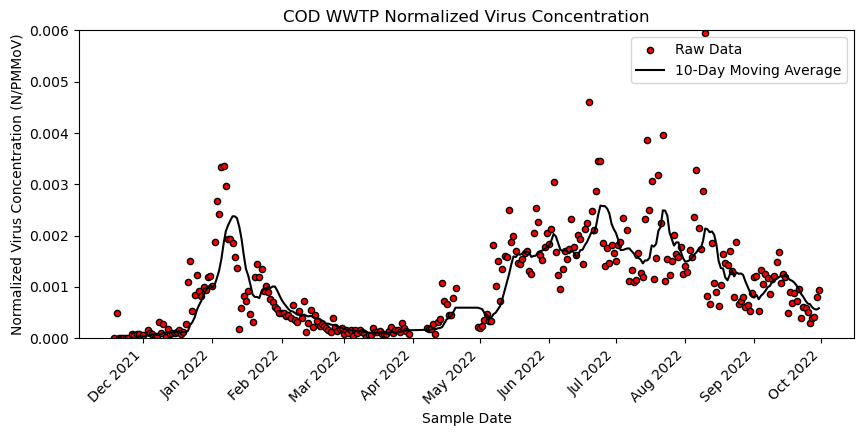

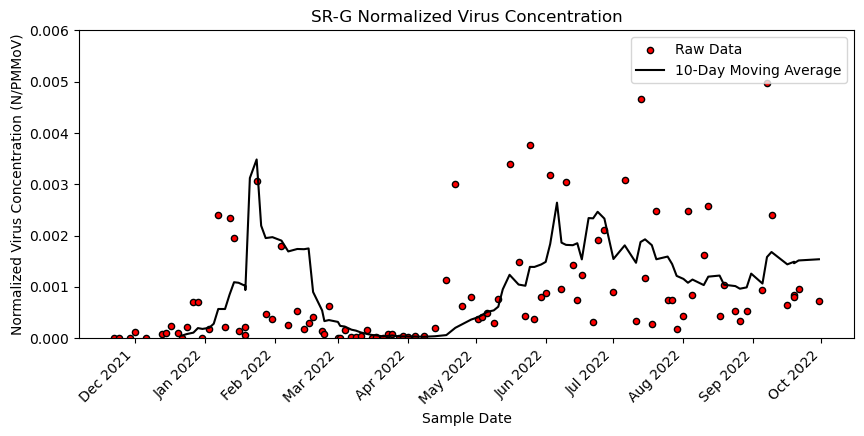

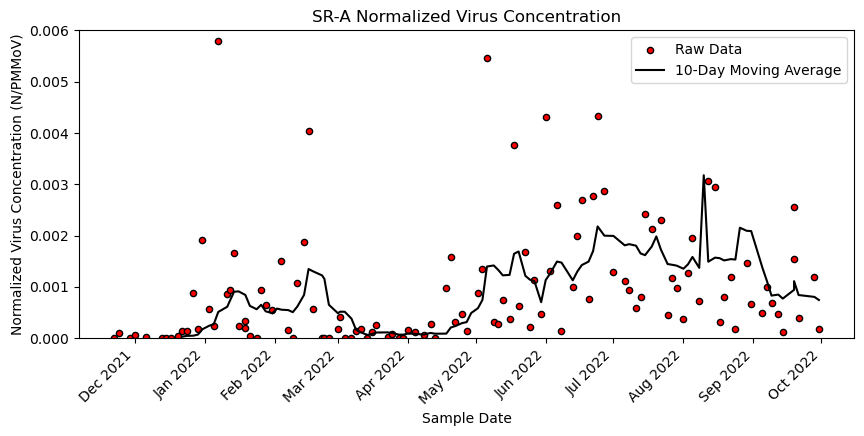

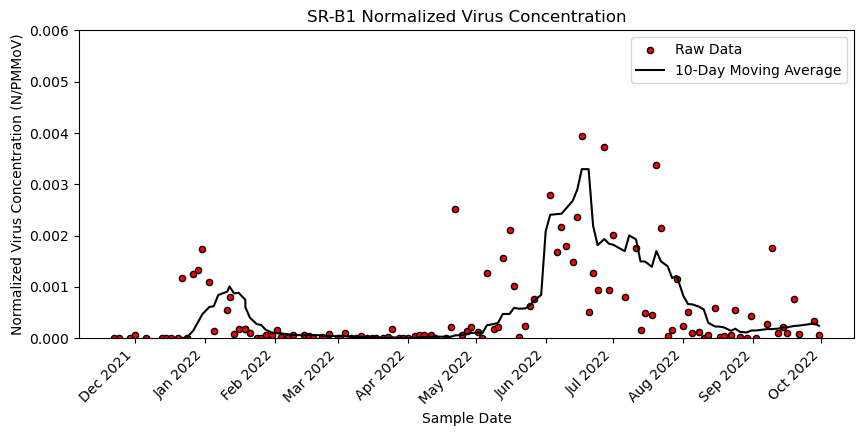

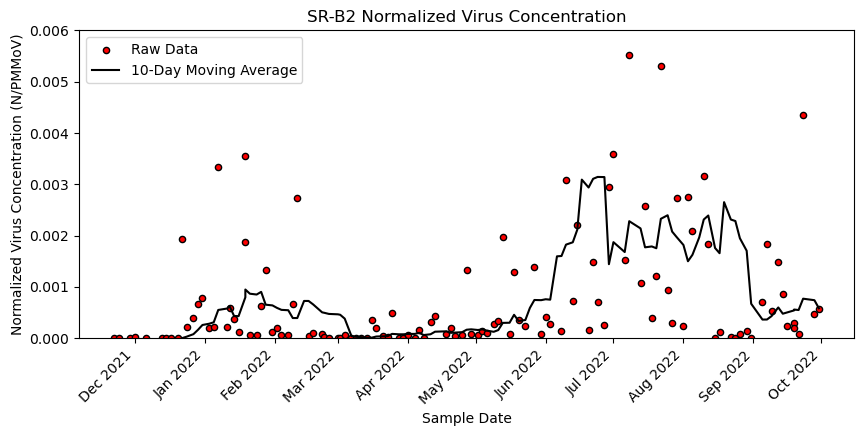

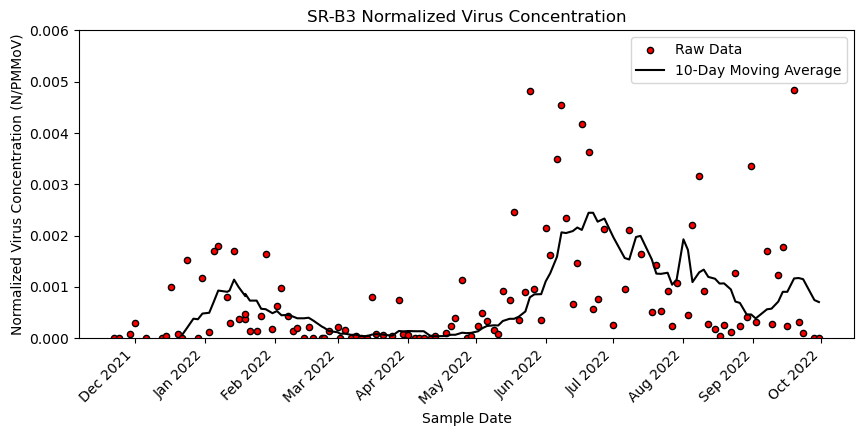

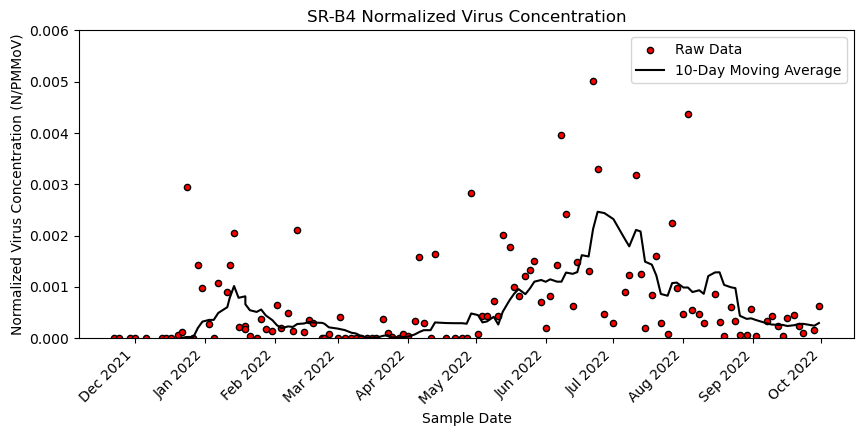

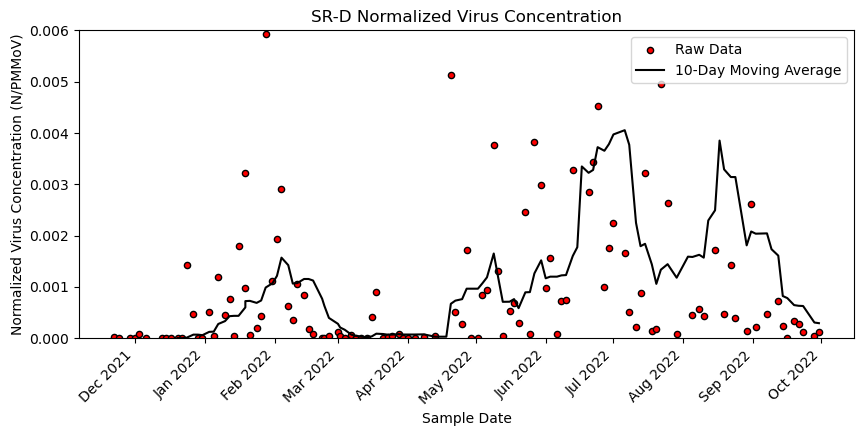

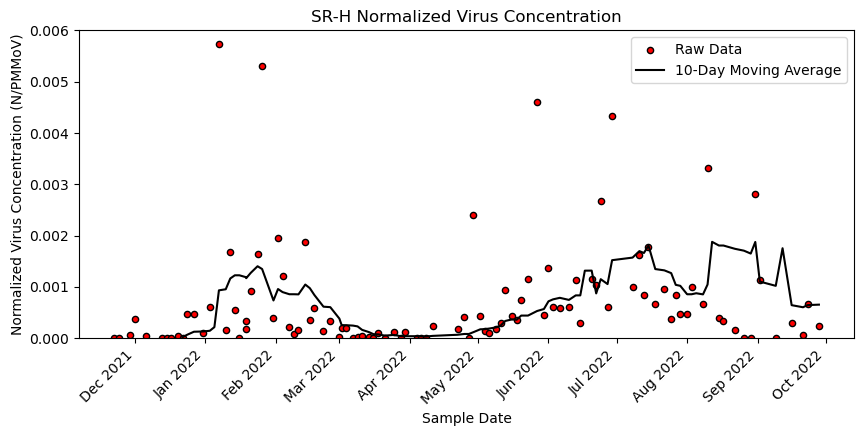

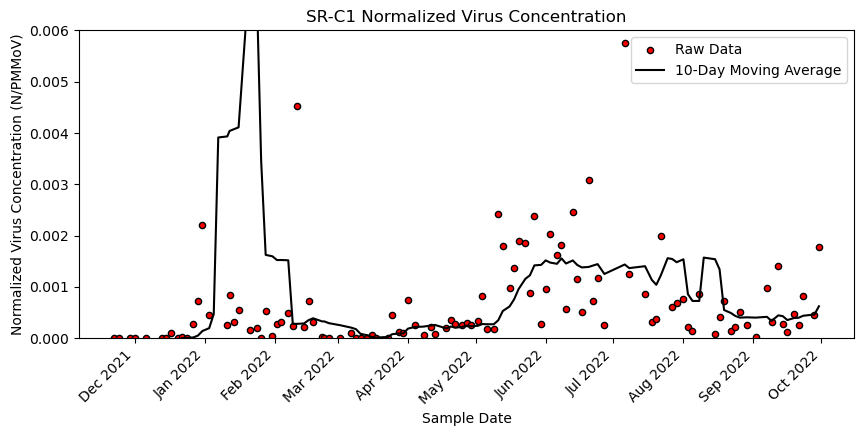

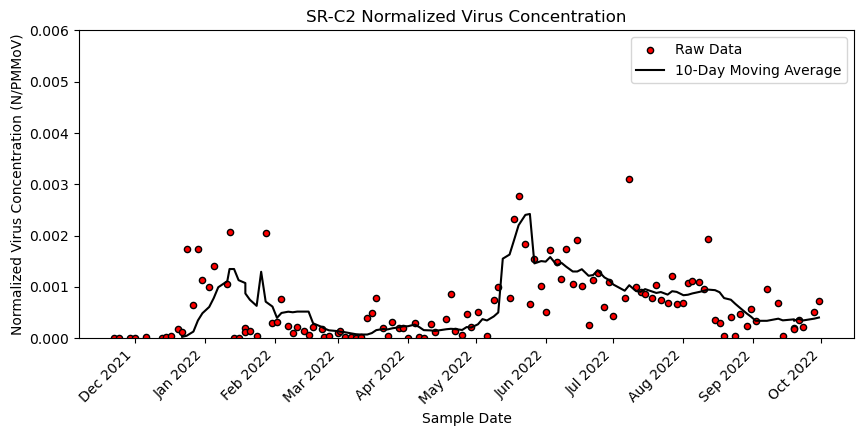

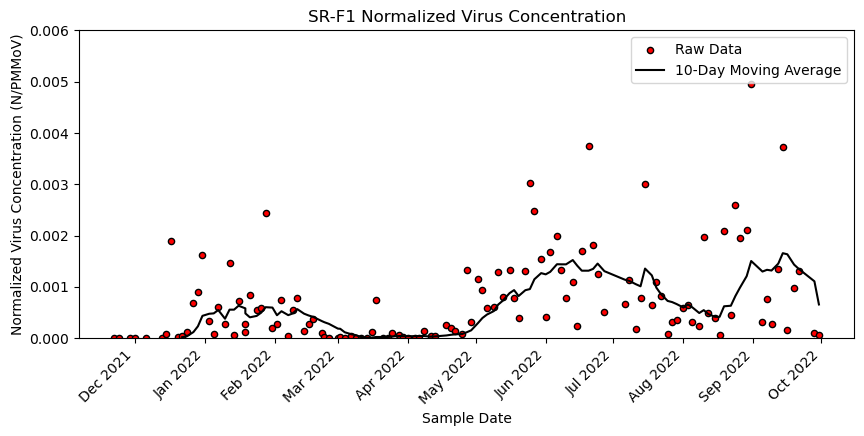

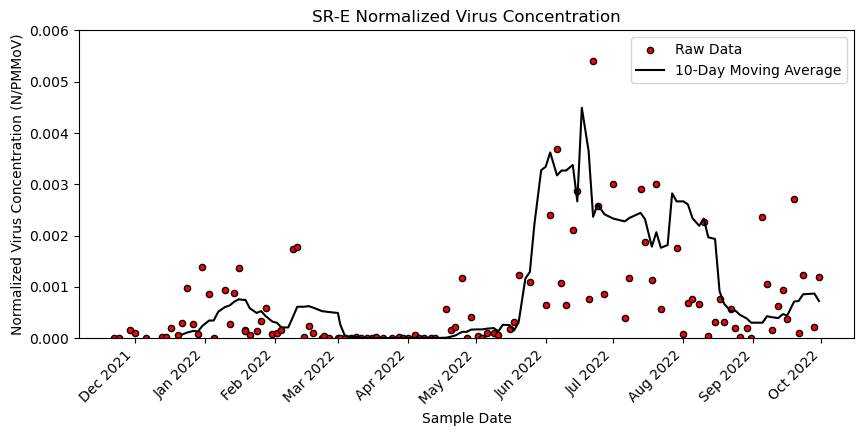

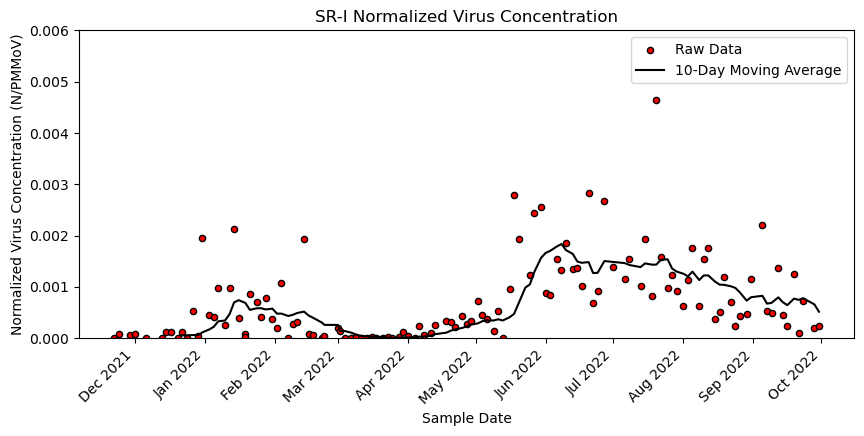

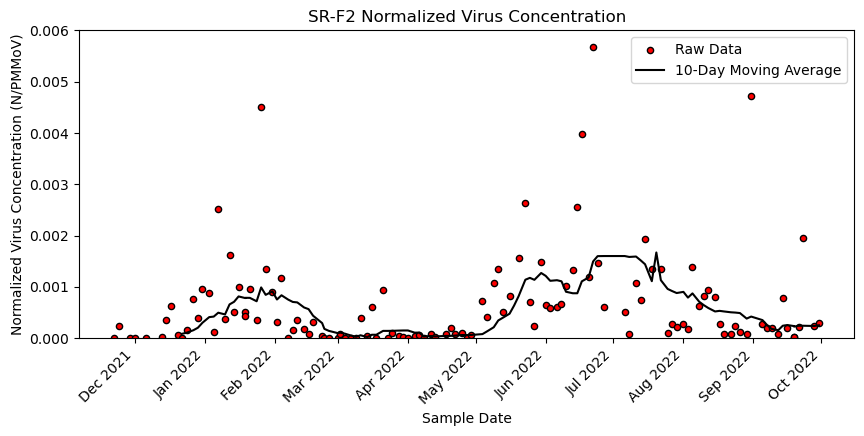

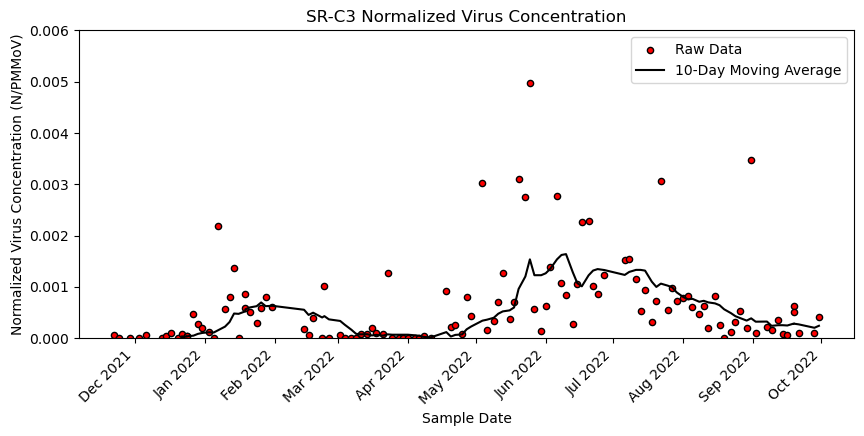

In [11]:
#Plotting the raw data and smoothed data for all sampling locations
moving_averages = []
all_dates = []
raw_data = []
for i in np.arange(len(sampling_locations)):
    
    ddpcr_results_loc = ddpcr_results[ddpcr_results["Location"]==sampling_locations[i]]
    ddpcr_results_loc = ddpcr_results_loc[["SampleDate","N/PMMoV"]]
    ddpcr_results_loc = ddpcr_results_loc.rename(columns={"N/PMMoV":"NormConc"})
    #changing to float
    ddpcr_results_loc["NormConc"] = pd.to_numeric(ddpcr_results_loc.NormConc, errors='coerce')
    x = ddpcr_results_loc["SampleDate"]
    x_split = x.str.split()
    dates = x_split.str[0]
    dates = pd.to_datetime(pd.Series(dates), format='%Y-%m-%d')
    all_dates.append(dates.tolist())
    y = ddpcr_results_loc["NormConc"]
   
    #10-day moving average
    ma = y.rolling(10).apply(lambda x: trim_mean(x, 0.1))
    moving_averages.append(ma.tolist())
    
    raw_data.append(y.tolist())
    
    #plotting
    plt.figure(figsize=(10,4))
    plt.scatter(dates,y,c="red",s=20,edgecolors="black",label="Raw Data")
    plt.plot(dates,ma,c="black",label="10-Day Moving Average")
    
    #formatting
    sampling_location_name = sewershed_zone_names[i]
    plt.title(sampling_location_name+" Normalized Virus Concentration")
    plt.xlabel("Sample Date")
    plt.ylabel("Normalized Virus Concentration (N/PMMoV)")
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.ylim(0,0.006)
    plt.show()

## Disease dynamics by sub-sewershed zone

In [12]:
#Changing NaN values to 0
nan = float('nan')
moving_averages = [[0 if math.isnan(i) else i for i in j] for j in moving_averages]

sewershed_zones["Sample Dates"] = all_dates
sewershed_zones["Moving Average"] = moving_averages
sewershed_zones["Raw Data"] = raw_data

all_pma = []
for i in np.arange(len(moving_averages)):
    pma = pd.Series(moving_averages[i])*sewershed_zone_pops[i]/COD_pop
    all_pma.append(pma.tolist())

sewershed_zones["Population-Weighted Moving Average"] = all_pma

#Changing values to floats
COD_WWTP_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][0]), format='%Y-%m-%d')
COD_WWTP_ma = sewershed_zones["Moving Average"][0]
CumuMA_COD_WWTP = pd.DataFrame(list(zip(COD_WWTP_dates,COD_WWTP_ma)))
CumuMA_COD_WWTP.columns = ["Sample Date","MA"]

COD_WWTP_pma = sewershed_zones["Population-Weighted Moving Average"][0]
CumuPMA_COD_WWTP = pd.DataFrame(list(zip(COD_WWTP_dates,COD_WWTP_pma)))
CumuPMA_COD_WWTP.columns = ["Sample Date","PMA"]

SR_G_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][1]), format='%Y-%m-%d')
SR_G_pma = sewershed_zones["Population-Weighted Moving Average"][1]
CumuPMA_SR_G = pd.DataFrame(list(zip(SR_G_dates,SR_G_pma)))
CumuPMA_SR_G.columns = ["Sample Date","PMA"]

SR_A_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][2]), format='%Y-%m-%d')
SR_A_pma = sewershed_zones["Population-Weighted Moving Average"][2]
CumuPMA_SR_A = pd.DataFrame(list(zip(SR_A_dates,SR_A_pma)))
CumuPMA_SR_A.columns = ["Sample Date","PMA"]

SR_B_1_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][3]), format='%Y-%m-%d')
SR_B_1_pma = sewershed_zones["Population-Weighted Moving Average"][3]
CumuPMA_SR_B_1 = pd.DataFrame(list(zip(SR_B_1_dates,SR_B_1_pma)))
CumuPMA_SR_B_1.columns = ["Sample Date","PMA"]

SR_B_2_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][4]), format='%Y-%m-%d')
SR_B_2_pma = sewershed_zones["Population-Weighted Moving Average"][4]
CumuPMA_SR_B_2 = pd.DataFrame(list(zip(SR_B_2_dates,SR_B_2_pma)))
CumuPMA_SR_B_2.columns = ["Sample Date","PMA"]

SR_B_3_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][5]), format='%Y-%m-%d')
SR_B_3_pma = sewershed_zones["Population-Weighted Moving Average"][5]
CumuPMA_SR_B_3 = pd.DataFrame(list(zip(SR_B_3_dates,SR_B_3_pma)))
CumuPMA_SR_B_3.columns = ["Sample Date","PMA"]

SR_B_4_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][6]), format='%Y-%m-%d')
SR_B_4_pma = sewershed_zones["Population-Weighted Moving Average"][6]
CumuPMA_SR_B_4 = pd.DataFrame(list(zip(SR_B_4_dates,SR_B_4_pma)))
CumuPMA_SR_B_4.columns = ["Sample Date","PMA"]

SR_D_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][7]), format='%Y-%m-%d')
SR_D_pma = sewershed_zones["Population-Weighted Moving Average"][7]
CumuPMA_SR_D = pd.DataFrame(list(zip(SR_D_dates,SR_D_pma)))
CumuPMA_SR_D.columns = ["Sample Date","PMA"]

SR_H_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][8]), format='%Y-%m-%d')
SR_H_pma = sewershed_zones["Population-Weighted Moving Average"][8]
CumuPMA_SR_H = pd.DataFrame(list(zip(SR_H_dates,SR_H_pma)))
CumuPMA_SR_H.columns = ["Sample Date","PMA"]

SR_C_1_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][9]), format='%Y-%m-%d')
SR_C_1_pma = sewershed_zones["Population-Weighted Moving Average"][9]
CumuPMA_SR_C_1 = pd.DataFrame(list(zip(SR_C_1_dates,SR_C_1_pma)))
CumuPMA_SR_C_1.columns = ["Sample Date","PMA"]

SR_C_2_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][10]), format='%Y-%m-%d')
SR_C_2_pma = sewershed_zones["Population-Weighted Moving Average"][10]
CumuPMA_SR_C_2 = pd.DataFrame(list(zip(SR_C_2_dates,SR_C_2_pma)))
CumuPMA_SR_C_2.columns = ["Sample Date","PMA"]

SR_F_1_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][11]), format='%Y-%m-%d')
SR_F_1_pma = sewershed_zones["Population-Weighted Moving Average"][11]
CumuPMA_SR_F_1 = pd.DataFrame(list(zip(SR_F_1_dates,SR_F_1_pma)))
CumuPMA_SR_F_1.columns = ["Sample Date","PMA"]

SR_E_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][12]), format='%Y-%m-%d')
SR_E_pma = sewershed_zones["Population-Weighted Moving Average"][12]
CumuPMA_SR_E = pd.DataFrame(list(zip(SR_E_dates,SR_E_pma)))
CumuPMA_SR_E.columns = ["Sample Date","PMA"]

SR_I_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][13]), format='%Y-%m-%d')
SR_I_pma = sewershed_zones["Population-Weighted Moving Average"][13]
CumuPMA_SR_I = pd.DataFrame(list(zip(SR_I_dates,SR_I_pma)))
CumuPMA_SR_I.columns = ["Sample Date","PMA"]

SR_F_2_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][14]), format='%Y-%m-%d')
SR_F_2_pma = sewershed_zones["Population-Weighted Moving Average"][14]
CumuPMA_SR_F_2 = pd.DataFrame(list(zip(SR_F_2_dates,SR_F_2_pma)))
CumuPMA_SR_F_2.columns = ["Sample Date","PMA"]

SR_C_3_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][15]), format='%Y-%m-%d')
SR_C_3_pma = sewershed_zones["Population-Weighted Moving Average"][15]
CumuPMA_SR_C_3 = pd.DataFrame(list(zip(SR_C_3_dates,SR_C_3_pma)))
CumuPMA_SR_C_3.columns = ["Sample Date","PMA"]

#Mean absolute error 
error_CODWWTP = sum(abs(np.subtract(sewershed_zones["Raw Data"][0],COD_WWTP_pma)))/len(sewershed_zones["Raw Data"][0])
error_SR_G = sum(abs(np.subtract(sewershed_zones["Raw Data"][1],SR_G_pma)))/len(sewershed_zones["Raw Data"][1])
error_SR_A = sum(abs(np.subtract(sewershed_zones["Raw Data"][2],SR_A_pma)))/len(sewershed_zones["Raw Data"][2])
error_SR_B_1 = sum(abs(np.subtract(sewershed_zones["Raw Data"][3],SR_B_1_pma)))/len(sewershed_zones["Raw Data"][3])
error_SR_B_2 = sum(abs(np.subtract(sewershed_zones["Raw Data"][4],SR_B_2_pma)))/len(sewershed_zones["Raw Data"][4])
error_SR_B_3 = sum(abs(np.subtract(sewershed_zones["Raw Data"][5],SR_B_3_pma)))/len(sewershed_zones["Raw Data"][5])
error_SR_B_4 = sum(abs(np.subtract(sewershed_zones["Raw Data"][6],SR_B_4_pma)))/len(sewershed_zones["Raw Data"][6])
error_SR_D = sum(abs(np.subtract(sewershed_zones["Raw Data"][7],SR_D_pma)))/len(sewershed_zones["Raw Data"][7])
error_SR_H = sum(abs(np.subtract(sewershed_zones["Raw Data"][8],SR_H_pma)))/len(sewershed_zones["Raw Data"][8])
error_SR_C_1 = sum(abs(np.subtract(sewershed_zones["Raw Data"][9],SR_C_1_pma)))/len(sewershed_zones["Raw Data"][9])
error_SR_C_2 = sum(abs(np.subtract(sewershed_zones["Raw Data"][10],SR_C_2_pma)))/len(sewershed_zones["Raw Data"][10])
error_SR_F_1 = sum(abs(np.subtract(sewershed_zones["Raw Data"][11],SR_F_1_pma)))/len(sewershed_zones["Raw Data"][11])
error_SR_E = sum(abs(np.subtract(sewershed_zones["Raw Data"][12],SR_E_pma)))/len(sewershed_zones["Raw Data"][12])
error_SR_I = sum(abs(np.subtract(sewershed_zones["Raw Data"][13],SR_I_pma)))/len(sewershed_zones["Raw Data"][13])
error_SR_F_2 = sum(abs(np.subtract(sewershed_zones["Raw Data"][14],SR_F_2_pma)))/len(sewershed_zones["Raw Data"][14])

#Won't be incorporating this because of overlap
error_SR_C_3 = sum(abs(np.subtract(sewershed_zones["Raw Data"][15],SR_C_3_pma)))/len(sewershed_zones["Raw Data"][15])

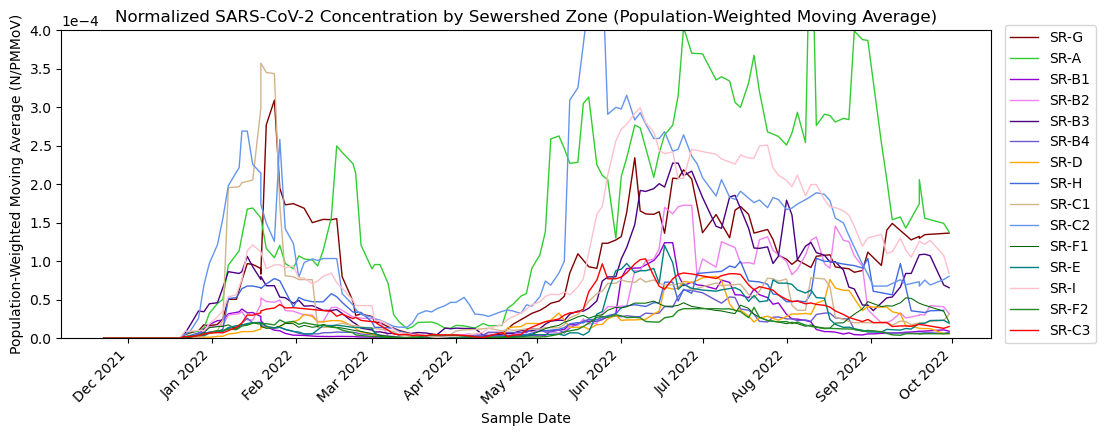

In [13]:
#Plotting
plt.figure(figsize=(12,4))

plt.plot(SR_G_dates,SR_G_pma,c="maroon",linewidth=1,label="SR-G")
plt.plot(SR_A_dates,SR_A_pma,c="limegreen",linewidth=1,label="SR-A")
plt.plot(SR_B_1_dates,SR_B_1_pma,c="darkviolet",linewidth=1,label="SR-B1")
plt.plot(SR_B_2_dates,SR_B_2_pma,c="violet",linewidth=1,label="SR-B2")
plt.plot(SR_B_3_dates,SR_B_3_pma,c="indigo",linewidth=1,label="SR-B3")
plt.plot(SR_B_4_dates,SR_B_4_pma,c="slateblue",linewidth=1,label="SR-B4")
plt.plot(SR_D_dates,SR_D_pma,c="orange",linewidth=1,label="SR-D")
plt.plot(SR_H_dates,SR_H_pma,c="royalblue",linewidth=1,label="SR-H")
plt.plot(SR_C_1_dates,SR_C_1_pma,c="tan",linewidth=1,label="SR-C1")
plt.plot(SR_C_2_dates,SR_C_2_pma,c="cornflowerblue",linewidth=1,label="SR-C2")
plt.plot(SR_F_1_dates,SR_F_1_pma,c="darkgreen",linewidth=0.75,label="SR-F1")
plt.plot(SR_E_dates,SR_E_pma,c="teal",linewidth=1,label="SR-E")
plt.plot(SR_I_dates,SR_I_pma,c="pink",linewidth=1,label="SR-I")
plt.plot(SR_F_2_dates,SR_F_2_pma,c="forestgreen",linewidth=1,label="SR-F2")
plt.plot(SR_C_3_dates,SR_C_3_pma,c="red",linewidth=1,label="SR-C3")

plt.title("Normalized SARS-CoV-2 Concentration by Sewershed Zone (Population-Weighted Moving Average)")
plt.xlabel("Sample Date")
plt.ylabel("Population-Weighted Moving Average (N/PMMoV)")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.12,0.5), loc="right")
plt.ylim(0,0.0004)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.show()

## Sub-sewershed zone and COD WWTP alignment

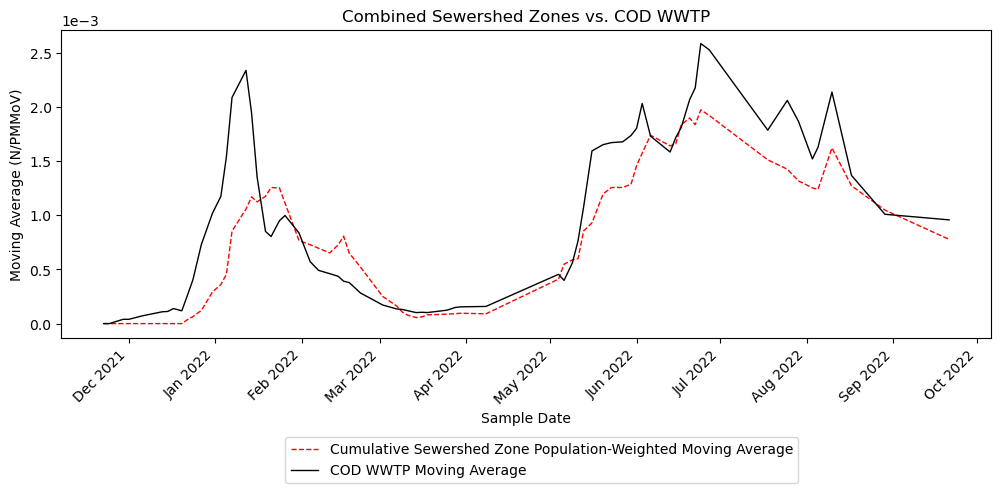

In [14]:
#Filtering for all points with shared x-values, didn't include SR-C3 because the entire zone is overlapped
shared_x = sorted(list(set.intersection(*map(set, [SR_G_dates, SR_A_dates,SR_B_1_dates,
                                           SR_B_2_dates,SR_B_3_dates,SR_B_4_dates,SR_D_dates,
                                           SR_H_dates,SR_C_1_dates,SR_C_2_dates,
                                           SR_F_1_dates,SR_E_dates,SR_I_dates,
                                           SR_F_2_dates,COD_WWTP_dates]))))

shared_x = pd.to_datetime(pd.Series(shared_x), format='%Y-%m-%d')

FilteredPMA_SR_G = CumuPMA_SR_G[CumuPMA_SR_G['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_A = CumuPMA_SR_A[CumuPMA_SR_A['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_1 = CumuPMA_SR_B_1[CumuPMA_SR_B_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_2 = CumuPMA_SR_B_2[CumuPMA_SR_B_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_3 = CumuPMA_SR_B_3[CumuPMA_SR_B_3['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_4 = CumuPMA_SR_B_4[CumuPMA_SR_B_4['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_D = CumuPMA_SR_D[CumuPMA_SR_D['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_H = CumuPMA_SR_H[CumuPMA_SR_H['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_1 = CumuPMA_SR_C_1[CumuPMA_SR_C_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_2 = CumuPMA_SR_C_2[CumuPMA_SR_C_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_1 = CumuPMA_SR_F_1[CumuPMA_SR_F_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_E = CumuPMA_SR_E[CumuPMA_SR_E['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_I = CumuPMA_SR_I[CumuPMA_SR_I['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_2 = CumuPMA_SR_F_2[CumuPMA_SR_F_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]


FilteredMA_COD_WWTP = CumuMA_COD_WWTP[CumuMA_COD_WWTP['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["MA"]
FilteredPMA_COD_WWTP = CumuPMA_COD_WWTP[CumuPMA_COD_WWTP['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]

#This step creates a dataframe with all the values and sums them.
#Two columns: cumulative and COD WWTP
filtered_pmas = [FilteredPMA_SR_G,FilteredPMA_SR_A,FilteredPMA_SR_B_1,FilteredPMA_SR_B_2,FilteredPMA_SR_B_3,FilteredPMA_SR_B_4,
                 FilteredPMA_SR_D,FilteredPMA_SR_H,FilteredPMA_SR_C_1,FilteredPMA_SR_C_2, FilteredPMA_SR_F_1,FilteredPMA_SR_E,FilteredPMA_SR_I,
                 FilteredPMA_SR_F_2]

cumu_pma = [sum(x) for x in zip(*filtered_pmas)]

cod_comparison = pd.DataFrame(list(zip(cumu_pma,FilteredMA_COD_WWTP)))
cod_comparison.columns = ["Cumulative Population-Weighted Moving Average","COD WWTP Moving Average"]
cod_comparison

#Plotting comparison summary plot
plt.figure(figsize=(12,4))
plt.plot(shared_x,cumu_pma,c="red",linewidth=1,linestyle='dashed',label="Cumulative Sewershed Zone Population-Weighted Moving Average")
plt.plot(shared_x,FilteredMA_COD_WWTP,c="black",linewidth=1,label="COD WWTP Moving Average")

plt.title("Combined Sewershed Zones vs. COD WWTP")
plt.xlabel("Sample Date")
plt.ylabel("Moving Average (N/PMMoV)")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(0.8,-0.3))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.ylim(0,0.0004)
plt.show()

In [15]:
#Calculating the correlation between the sub-sewershed wastewater data and the COD WWTP wastewater data
corr_overall = spearmanr(cumu_pma, FilteredMA_COD_WWTP)
corr_overall

SpearmanrResult(correlation=0.9091658733428469, pvalue=5.884682827233102e-28)

In [16]:
#Error propagation
error_cumupma = np.sqrt(error_SR_G**2+error_SR_A**2+error_SR_B_1**2+error_SR_B_2**2+error_SR_B_3**2+error_SR_B_4**2+error_SR_D**2+error_SR_H**2+error_SR_C_1**2+error_SR_C_2**2+error_SR_F_1**2+error_SR_E**2+error_SR_I**2+error_SR_F_2**2)
error_CODWWTP = sum(abs(np.subtract(sewershed_zones["Raw Data"][0],COD_WWTP_pma)))/len(sewershed_zones["Raw Data"][0])
error_CODWWTP

0.0003600202426174497

In [23]:
#Correlation of wastewater data for each sub-sewershed zone (population-weighted moving average) with the overall COD WWTP data (moving average).

FilteredPMA_SR_G = CumuPMA_SR_G[CumuPMA_SR_G['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_A = CumuPMA_SR_A[CumuPMA_SR_A['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_1 = CumuPMA_SR_B_1[CumuPMA_SR_B_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_2 = CumuPMA_SR_B_2[CumuPMA_SR_B_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_3 = CumuPMA_SR_B_3[CumuPMA_SR_B_3['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_4 = CumuPMA_SR_B_4[CumuPMA_SR_B_4['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_D = CumuPMA_SR_D[CumuPMA_SR_D['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_H = CumuPMA_SR_H[CumuPMA_SR_H['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_1 = CumuPMA_SR_C_1[CumuPMA_SR_C_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_2 = CumuPMA_SR_C_2[CumuPMA_SR_C_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_1 = CumuPMA_SR_F_1[CumuPMA_SR_F_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_E = CumuPMA_SR_E[CumuPMA_SR_E['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_I = CumuPMA_SR_I[CumuPMA_SR_I['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_2 = CumuPMA_SR_F_2[CumuPMA_SR_F_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]

corr_SR_G = spearmanr(FilteredPMA_SR_G, FilteredMA_COD_WWTP)
corr_SR_A = spearmanr(FilteredPMA_SR_A, FilteredMA_COD_WWTP)
corr_SR_B_1 = spearmanr(FilteredPMA_SR_B_1, FilteredMA_COD_WWTP)
corr_SR_B_2 = spearmanr(FilteredPMA_SR_B_2, FilteredMA_COD_WWTP)
corr_SR_B_3 = spearmanr(FilteredPMA_SR_B_3, FilteredMA_COD_WWTP)
corr_SR_B_4 = spearmanr(FilteredPMA_SR_B_4, FilteredMA_COD_WWTP)
corr_SR_D = spearmanr(FilteredPMA_SR_D, FilteredMA_COD_WWTP)
corr_SR_H = spearmanr(FilteredPMA_SR_H, FilteredMA_COD_WWTP)
corr_SR_C_1 = spearmanr(FilteredPMA_SR_C_1, FilteredMA_COD_WWTP)
corr_SR_C_2 = spearmanr(FilteredPMA_SR_C_2, FilteredMA_COD_WWTP)
corr_SR_F_1 = spearmanr(FilteredPMA_SR_F_1, FilteredMA_COD_WWTP)
corr_SR_E = spearmanr(FilteredPMA_SR_E, FilteredMA_COD_WWTP)
corr_SR_I = spearmanr(FilteredPMA_SR_I, FilteredMA_COD_WWTP)
corr_SR_F_2 = spearmanr(FilteredPMA_SR_F_2, FilteredMA_COD_WWTP)

indiv_correlations = [corr_SR_G[0],corr_SR_A[0],corr_SR_B_1[0],
                      corr_SR_B_2[0],corr_SR_B_3[0],corr_SR_B_4[0],
                      corr_SR_D[0],corr_SR_H[0],corr_SR_C_1[0],corr_SR_C_2[0],
                      corr_SR_F_1[0],corr_SR_E[0],corr_SR_I[0],corr_SR_F_2[0]]
pvals = [corr_SR_G[1],corr_SR_A[1],corr_SR_B_1[1],
         corr_SR_B_2[1],corr_SR_B_3[1],corr_SR_B_4[1],
         corr_SR_D[1],corr_SR_H[1],corr_SR_C_1[1],corr_SR_C_2[1],
         corr_SR_F_1[1],corr_SR_E[1],corr_SR_I[1],corr_SR_F_2[1]]
zones = sewershed_zone_names[1:15]

zones
indiv_corr_table = pd.DataFrame(list(zip(zones,indiv_correlations,pvals)))
indiv_corr_table.columns = ["Name","Correlation (%)","P-Value"]
pd.set_option("display.precision", 3)
indiv_corr_table

,Name,Correlation (%),P-Value
0,SR-G,0.738,2.199e-13
1,SR-A,0.770,4.188e-15
2,SR-B1,0.935,8.811e-33
3,SR-B2,0.836,1.237e-19
4,SR-B3,0.927,4.695e-31
5,SR-B4,0.922,3.263e-30
6,SR-D,0.734,3.151e-13
7,SR-H,0.732,3.880e-13
8,SR-C1,0.793,1.692e-16
9,SR-C2,0.890,3.218e-25
